# Interpredictability test
comparing the two labelers of MASS

maximum prediction length 5s

-------------------------------------------------------

In [73]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [74]:
samplerate=200  #Should rethink this

In [75]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [76]:
#consider to include this in a function
minDuration=0.3
maxDuration=2.9
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [77]:
#check with EDA results (not needed)
print(1-len(annotations)/33458)

0.011297746428357902


In [78]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [79]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Defining the IoU matrix

In [80]:
#threshold for the metric by event
masterIoU=0.2

In [81]:
def getIou(coordA,coordB):
    if (coordA[1]<coordB[0])|(coordB[1]<coordA[0]): #NOT INTERSECTION
        iou=0
    else:   #INTERSECTION
        inter=np.min((coordA[1]-coordB[0],coordB[1]-coordA[0]))
        union=np.max((coordA[1]-coordB[0],coordB[1]-coordA[0]))
        iou=inter/union
    return iou

def getIoUmatrix(annotations,detections):
    #get the coords
    gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    return iouMatrix

def IoUmatrixToF1(iouMatrix,thresIoU=0.2):
    #binarize
    binarized=iouMatrix>thresIoU
    #calculateF1
    outF1=(np.sum(np.max(binarized,axis=0))+np.sum(np.max(binarized,axis=1)))/(iouMatrix.shape[0]+iouMatrix.shape[1])
    return outF1


In [82]:
subjectId='0007'

In [83]:
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId=='0007'].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId=='0007'].reset_index(drop=True)

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\1081862330.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId=='0007'].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\1081862330.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId=='0007'].reset_index(drop=True)


In [84]:
len(annotations1)

912

In [85]:
len(annotations2)

1571

In [86]:
IoUmatrix=getIoUmatrix(annotations1,annotations2)

In [87]:
IoUmatrix.shape

(912, 1571)

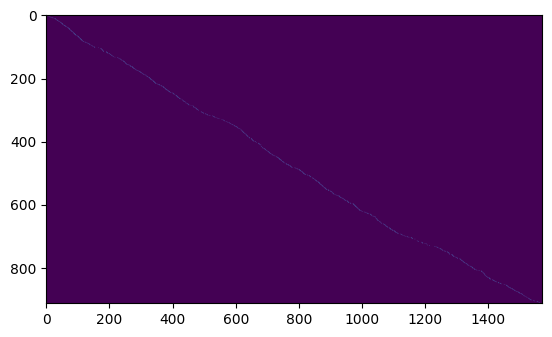

In [88]:
plt.imshow(IoUmatrix)

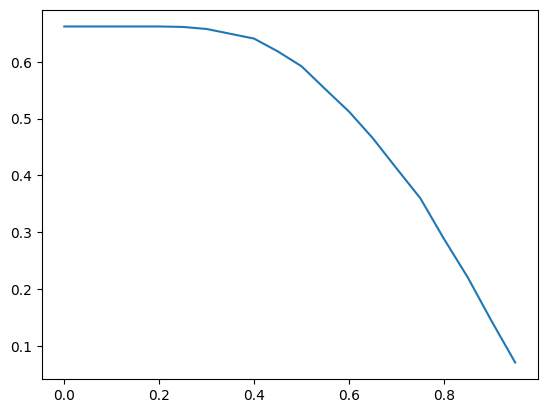

In [89]:
sampleIoUs=np.linspace(0,0.95,20)
sampleF1=[]

for thresIoU in sampleIoUs:
    sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

plt.plot(sampleIoUs,sampleF1)

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\3186219920.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\3186219920.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)


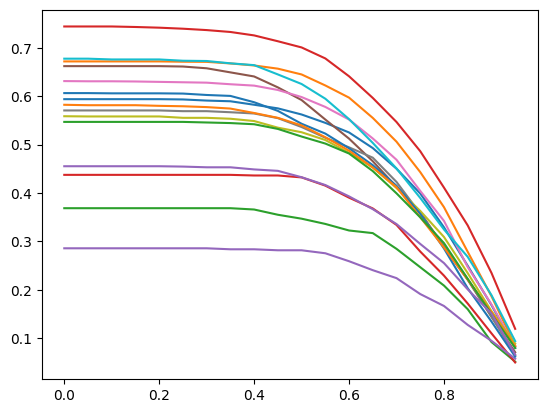

In [90]:
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)
    IoUmatrix=getIoUmatrix(annotations1,annotations2)
    
    sampleF1=[]
    for thresIoU in sampleIoUs:
        sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

    plt.plot(sampleIoUs,sampleF1)
plt.show()

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\851316360.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\851316360.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)


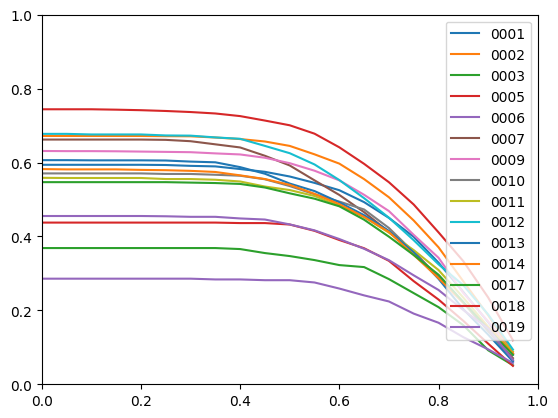

In [91]:
sampleF1_0=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)
    IoUmatrix=getIoUmatrix(annotations1,annotations2)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_0[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1
plt.plot(sampleIoUs,sampleF1_0)
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend(np.unique(annotations[annotations.labelerId=='0002'].subjectId))

Text(0, 0.5, 'F1*')

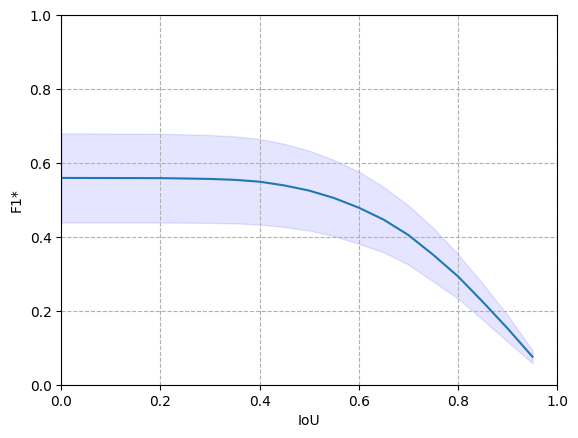

In [92]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1))
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')


## labeler1 model predicts labeler2

In [93]:
experimentId="f9bdb803-d62d-4eb1-a3a6-cd124daf73d0"

In [94]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [95]:
experimentModels1=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels2=experimentModels[experimentModels.criteriumName=='E2'].reset_index(drop=True)

In [96]:
#Hyper params for E1
hyperClose=0.25
hyperDuration=0.3
hyperThres=0.3
hyperDepth=30

In [97]:
annotationsN2=pd.read_csv(datapath+'/MASS/annotations/spindlesFilteredN2.csv')
annotationsN2['samplerate']=samplerate
annotationsN2['subjectId']=annotationsN2.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
annotationsN2['labelerId']=annotationsN2.apply(
    lambda row: str(row.labelerId).zfill(4),axis=1)
annotationsN2['stopTime']=annotationsN2.apply(
    lambda row: row.startTime+row.duration , axis=1)
annotationsN2['startInd']=annotationsN2.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
annotationsN2['stopInd']=annotationsN2.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)

In [98]:
## load hypnograms
stagesAnnotations=pd.read_csv(datapath+"\MASS\stages\stages.csv")
stagesAnnotations['samplerate']=samplerate
stagesAnnotations['subjectId']=stagesAnnotations.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
stagesAnnotations['stopTime']=stagesAnnotations.apply(
    lambda row: row.startTime+row.duration , axis=1)
stagesAnnotations['startInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
stagesAnnotations['stopInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
stagesAnnotations.head(5)

hypnograms={}
for ind, row in signalsMetadata.iterrows():
    subjectId=row.subjectId
    thisStages=stagesAnnotations[stagesAnnotations.subjectId==subjectId]
    excerptDimension=int(row.duration*row.samplerate)
    thisHypnogram=np.ones((excerptDimension,))*np.nan
    for ind_stg, row_stg in thisStages.iterrows():
        thisHypnogram[row_stg.startInd:row_stg.stopInd]=row_stg.value
    hypnograms[subjectId]=thisHypnogram   

In [99]:
sampleF1_1=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for ind,row in experimentModels1.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels1)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    
    #Define annotations criterium   *********************************************
    usedAnnotations=annotationsN2[annotationsN2.labelerId=='0002'].reset_index(drop=True)
    #***************************************************************************

    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    
    #**********************************************
    processedAnnotations=processedAnnotations[processedAnnotations.duration<5]
    #**********************************************

    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    
    IoUmatrix=getIoUmatrix(gtAnnotations,processedAnnotations)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_1[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1    
    

*************************
1 of 15
*************************
2 of 15
*************************
3 of 15
*************************
4 of 15
*************************
5 of 15
*************************
6 of 15
*************************
7 of 15
*************************
8 of 15
*************************
9 of 15
*************************
10 of 15
*************************
11 of 15
*************************
12 of 15
*************************
13 of 15
*************************
14 of 15
*************************
15 of 15


## labeler2 model predicts labeler1

In [100]:
#Hyper params for E2
hyperClose=0.25
hyperDuration=0.3
hyperThres=0.3
hyperDepth=30

In [101]:
sampleF1_2=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for ind,row in experimentModels2.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels2)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    
    #Define annotations criterium   *********************************************
    usedAnnotations=annotationsN2[annotationsN2.labelerId=='0001'].reset_index(drop=True)
    #***************************************************************************

    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    
    #**********************************************
    processedAnnotations=processedAnnotations[processedAnnotations.duration<5]
    #**********************************************
    
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    
    IoUmatrix=getIoUmatrix(gtAnnotations,processedAnnotations)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_2[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1    

*************************
1 of 15


*************************
2 of 15
*************************
3 of 15
*************************
4 of 15
*************************
5 of 15
*************************
6 of 15
*************************
7 of 15
*************************
8 of 15
*************************
9 of 15
*************************
10 of 15
*************************
11 of 15
*************************
12 of 15
*************************
13 of 15
*************************
14 of 15
*************************
15 of 15


## Interpredictability test

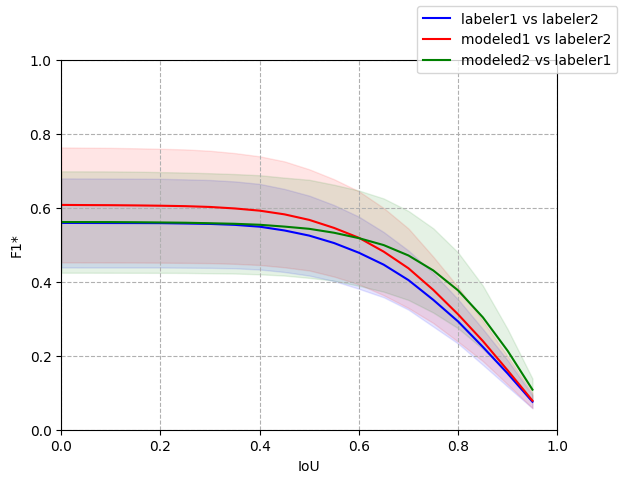

In [102]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='r')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='g')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='r', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='g', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])

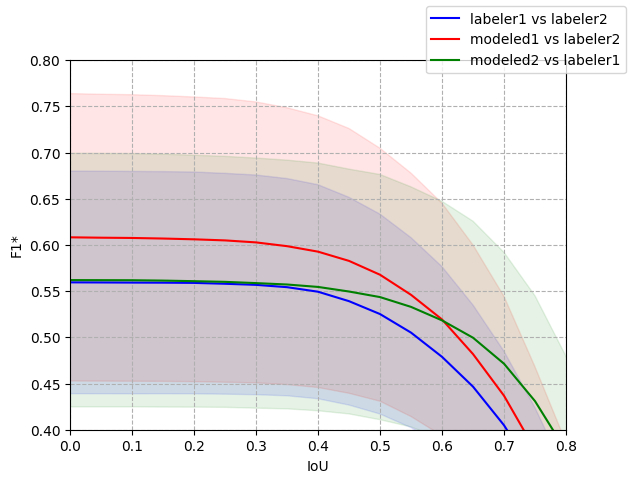

In [103]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='r')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='g')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='r', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='g', alpha=.1)
ax.set_xlim([0, 0.8])
ax.set_ylim([0.4, 0.8])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])

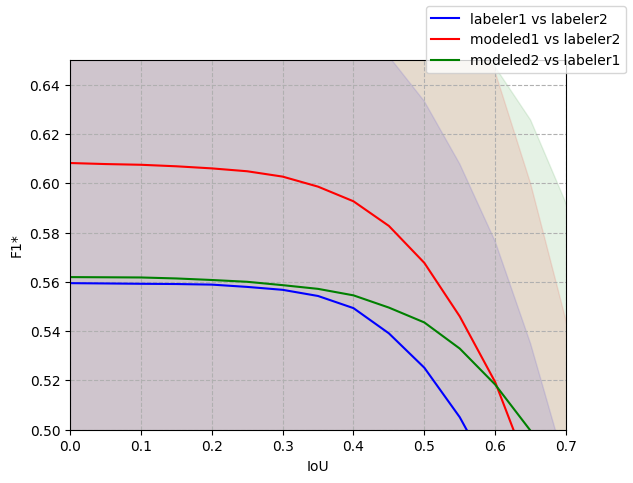

In [111]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='r')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='g')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='r', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='g', alpha=.1)
ax.set_xlim([0, 0.7])
ax.set_ylim([0.5, 0.65])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])

In [104]:
experimentModels2.test[0]

'0001'

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_13196\1409639086.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


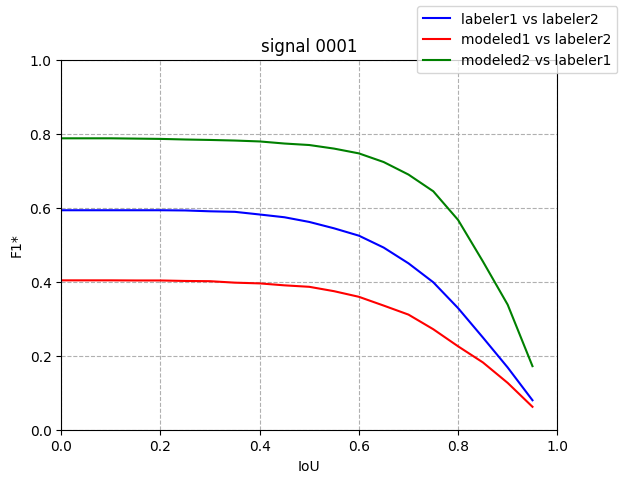

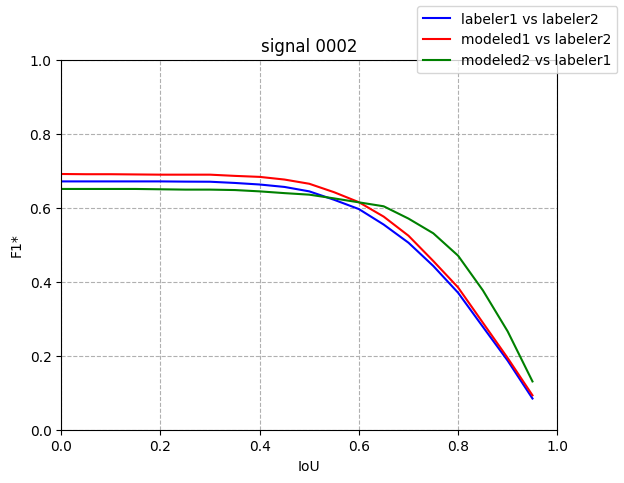

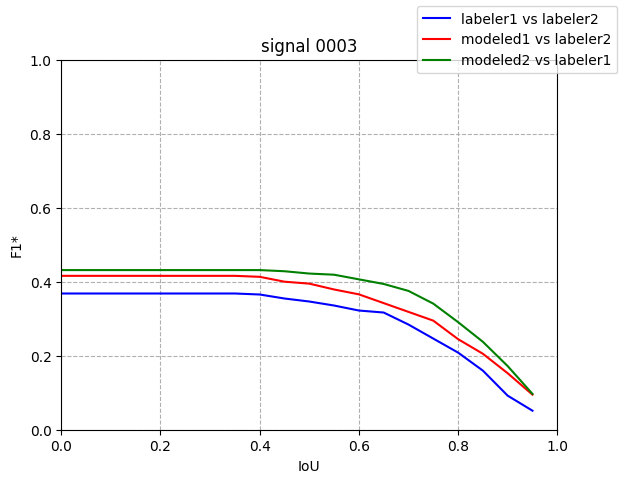

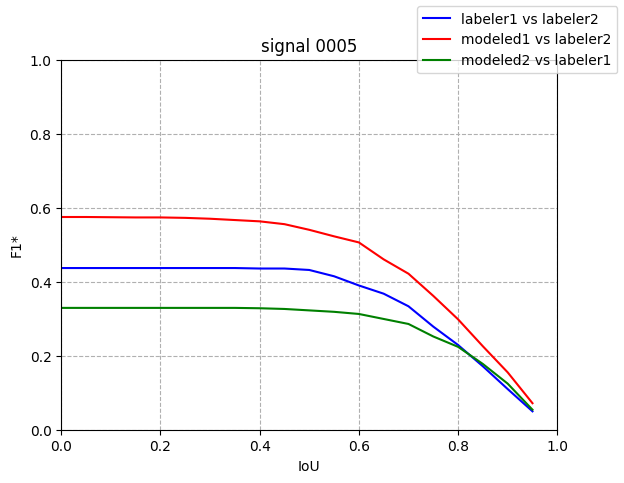

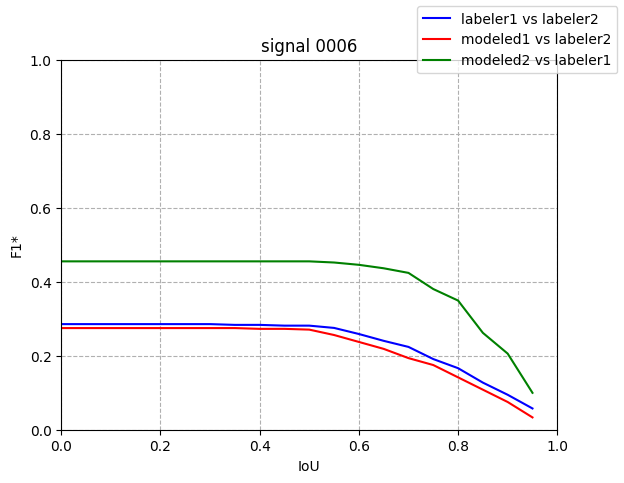

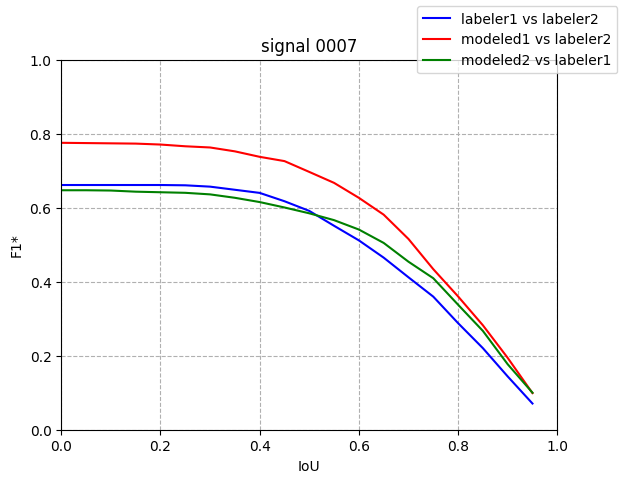

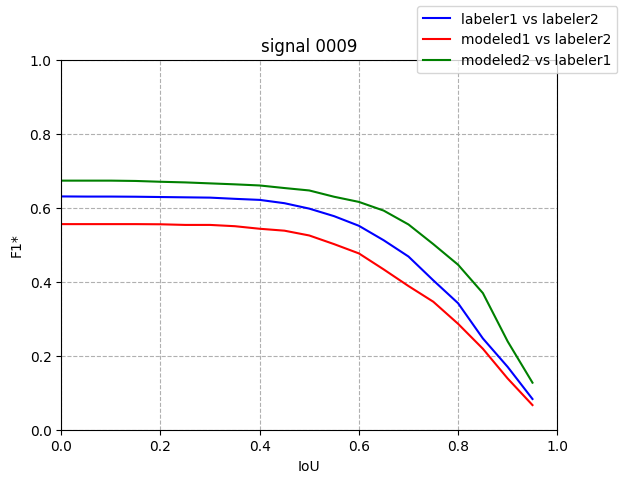

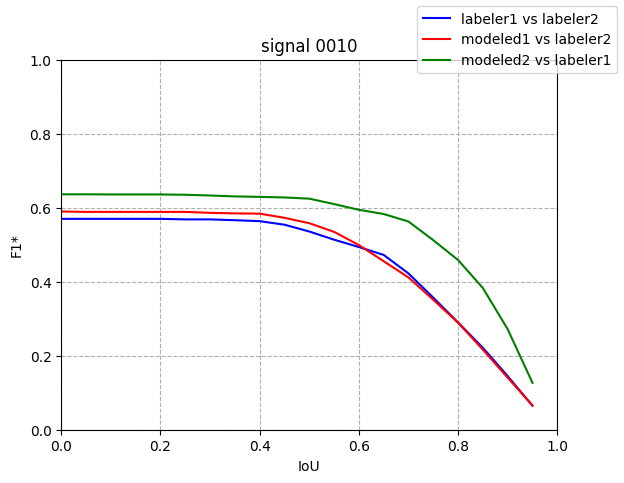

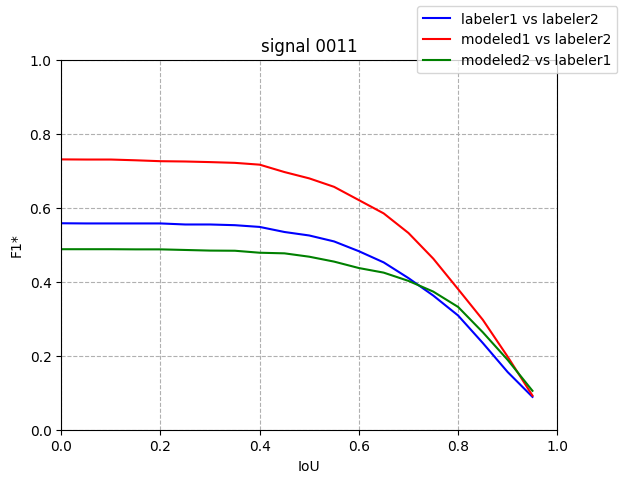

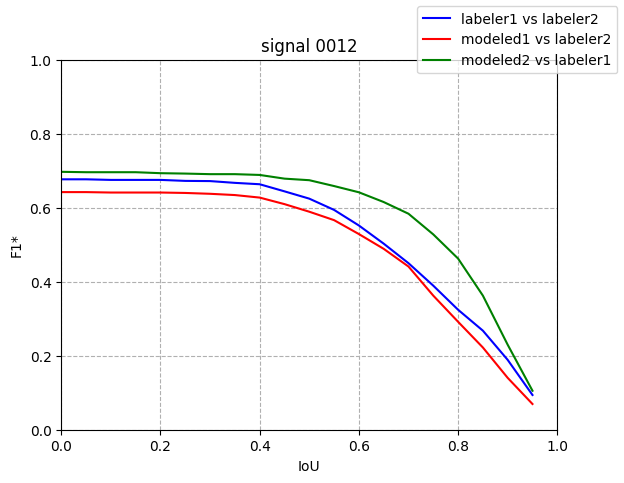

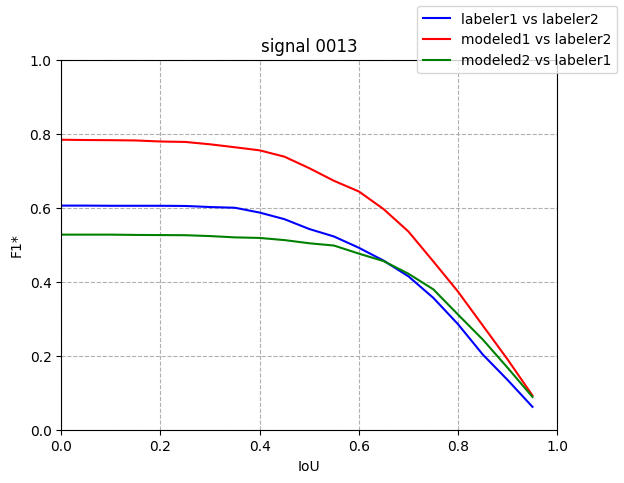

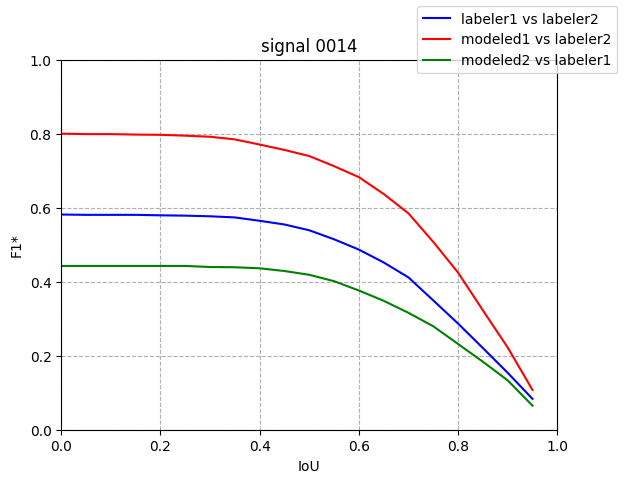

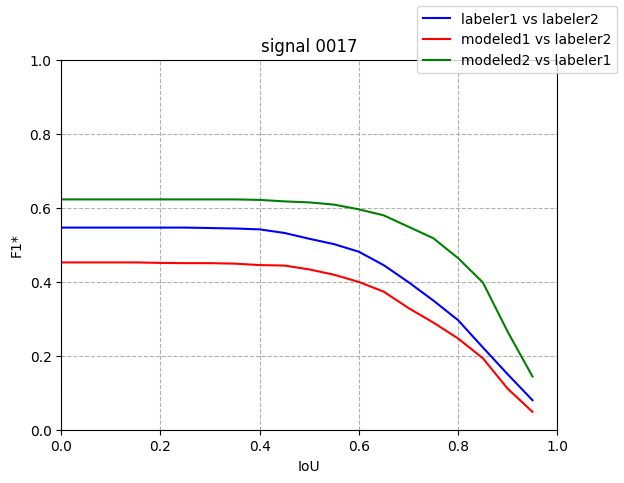

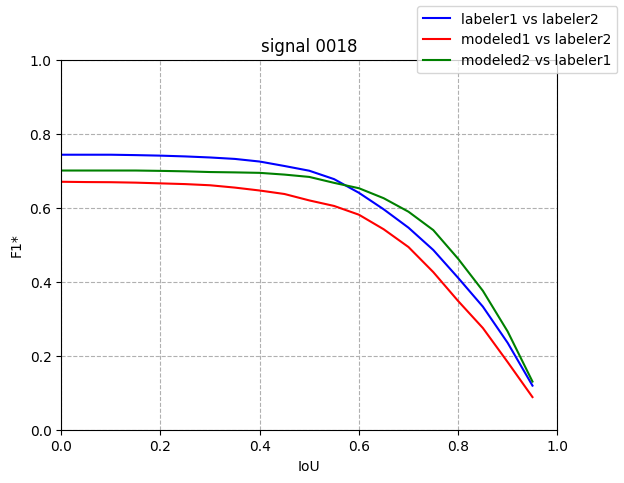

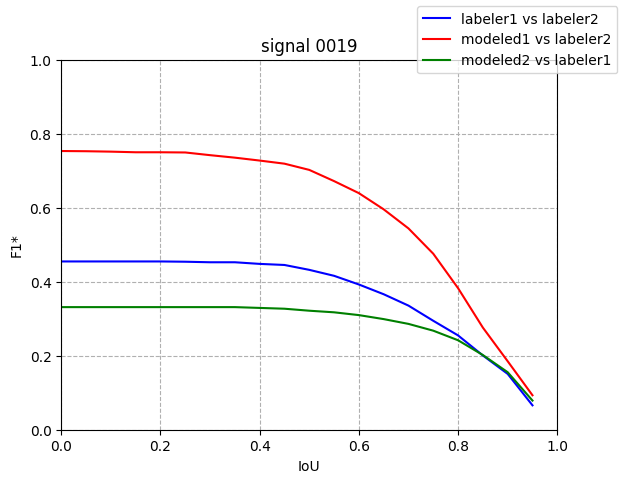

In [105]:
for i in range(sampleF1_0.shape[1]):
    fig, ax = plt.subplots()
    ax.grid(linestyle='--')
    ax.plot(sampleIoUs,sampleF1_0[:,i].flatten(),color='b')
    ax.plot(sampleIoUs,sampleF1_1[:,i],color='r')
    ax.plot(sampleIoUs,sampleF1_2[:,i],color='g')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('IoU')
    ax.set_ylabel('F1*')
    fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])
    plt.title('signal '+experimentModels2.test[i])
    fig.show()

In [106]:
sampleF1_3=(sampleF1_1+sampleF1_2)/2

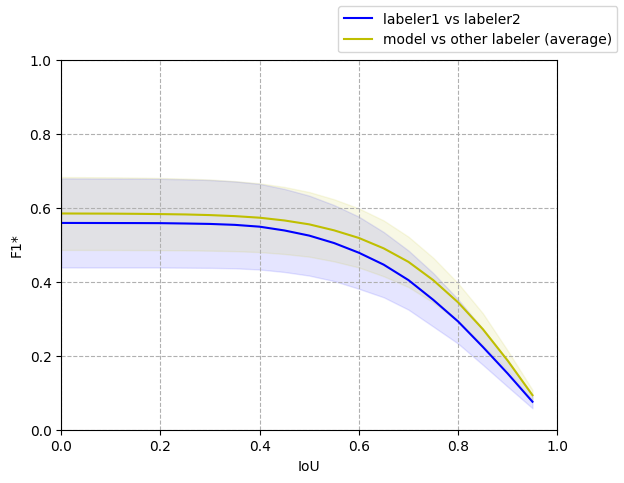

In [107]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='y', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,1])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','model vs other labeler (average)'])

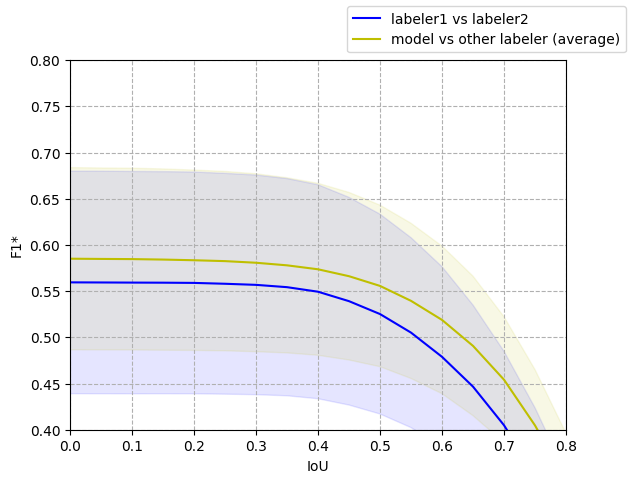

In [108]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='y', alpha=.1)
ax.set_xlim([0, 0.8])
ax.set_ylim([0.4,0.8])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','model vs other labeler (average)'])